In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import Adam
import numpy as np
import pickle

import copy
import gym
from gym import spaces

import matplotlib.pyplot as plt
%matplotlib inline

from NeuralNetworks import MLPActor, compute_loss_pi, MLP, ReplayBuffer

In [63]:
def compute_loss_safe(learned_policy, data, safety_threshold):
    o, a = data['sta'], data['act']
    safe_pred = learned_policy.pi_safe(o).squeeze()
    a_pred = learned_policy.pi(o).detach()
    targets = torch.lt(torch.sum((a - a_pred)**2, dim=1), safety_threshold).float().detach()
    return torch.nn.BCELoss()(safe_pred, targets)

In [64]:
# plt set config
def set_plt_cfg():
    plt.xlim(-15., 15)
    plt.ylim(-3., 3.)
    plt.xlabel('Independent varible')
    plt.ylabel('Dependent varible')
    plt.legend()

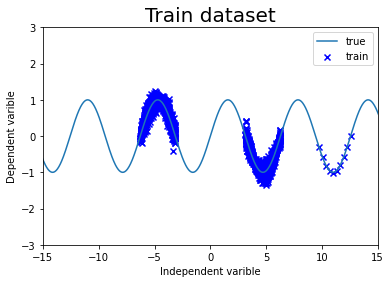

In [65]:
device = torch.device('cuda')

torch.manual_seed(1)    # reproducible
true_x = torch.unsqueeze(torch.linspace(-5*np.pi, 5*np.pi, 1000), dim=1)
true_y = torch.sin(true_x)
plt.plot(true_x,true_y, label='true')

x_1 = torch.unsqueeze(torch.linspace(-2*np.pi, -np.pi, 1000), dim=1)
x_2 = torch.unsqueeze(torch.linspace(np.pi, 2*np.pi, 1000), dim=1)
x_3 = torch.unsqueeze(torch.linspace(3.1*np.pi, 4*np.pi, 10), dim=1)
train_x = torch.concat([x_1,x_2])

y_1 = torch.sin(train_x) \
        + (((0.0225*abs(torch.sin(1.5*train_x + np.pi/8))).sqrt())
        *(torch.randn(train_x.shape)))
y_2 = torch.sin(x_3) + (torch.randn(x_3.shape))*0.01
train_x = torch.concat([x_1,x_2,x_3])
train_y = torch.concat([y_1,y_2])

# torch can only train on Variable, so convert them to Variable
train_x, train_y = Variable(train_x), Variable(train_y)
train_dataset = {"sta": train_x.to(device), "act": train_y.to(device)}

plt.scatter(train_x.data.numpy(), train_y.data.numpy(), color="blue",marker='x',label='train')

plt.title('Train dataset',fontsize=20)
set_plt_cfg()
plt.show()


In [66]:
# Set ensemble model ----------------------------
# set gym action / state space
action_space = spaces.Box(
    np.array([-1]).astype(np.float32),
    np.array([1]).astype(np.float32),
)
state_space = spaces.Box(
    np.array([-10.]).astype(np.float32),
    np.array([10.]).astype(np.float32),
)
pi_lr = 1e-3
pi_safe_lr = 1e-3

ac_0 = MLP(state_space=state_space,
              action_space=action_space,
              hidden_sizes=(256, 256),
              activation=nn.Hardswish,
              device=device,
              Glorot_init=True,
              Glorot_gain=3.0,)


loss_func_pi = compute_loss_pi  # this is for regression mean squared loss
loss_func_safe = compute_loss_safe

In [69]:
# Ploting initial model regression resulting ----------------------
def plot_model(model,title:str()):
    plt.cla()
    
    # plot trained datasets
    plt.scatter(train_x.data.numpy(), train_y.data.numpy(), color="blue", marker='x', label='train')

    predictions = []
    test_range = [-15., 15.]
    test_state = torch.unsqueeze(torch.linspace(
        test_range[0], test_range[1], 3000), dim=1).to(device)  # x data (tensor), shape=(100, 1)

    mm = model.act(test_state)
    cc = model.classify(test_state)

    # plot predicted results
    plt.plot(test_state.cpu().numpy(), mm, color='red', alpha=1, label="predicted")
    plt.fill_between(test_state.cpu().numpy().squeeze(), -3, 3, where=cc < 0.5,color='red', alpha=0.5, label="risky")
    
    plt.title(title,fontsize=20)
    set_plt_cfg()
    plt.show()

# Checking init model with risky state

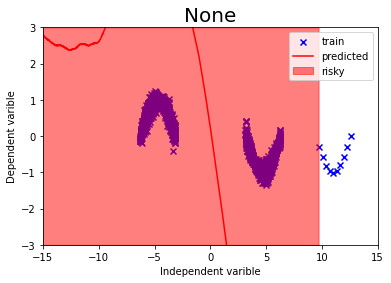

In [70]:
plot_model(model=ac_0,title='None')

# Learning models

In [71]:
# Experience buffer
sta_dim = 1
act_dim = 1
replay_size = int(3e4)
replay_buffer = ReplayBuffer(
    sta_dim=sta_dim, act_dim=act_dim, size=replay_size, device=device)
# set aside Dsafe
safe_buffer = ReplayBuffer(sta_dim=sta_dim, act_dim=act_dim, size=replay_size, device=device)
input_data = {"sta": train_x, "act": train_y}
# shuffle and create small held out set to check valid loss
num_bc = len(input_data['sta'])
idxs = np.arange(num_bc)
np.random.shuffle(idxs)
replay_buffer.fill_buffer(
    input_data['sta'][idxs][:int(0.9 * num_bc)],
    input_data['act'][idxs][:int(0.9 * num_bc)])
safe_buffer.fill_buffer(input_data['sta'], input_data['act'])
held_out_data = {
    'sta': input_data['sta'][idxs][int(0.9 * num_bc):],
    'act': input_data['act'][idxs][int(0.9 * num_bc):]}

In [72]:

BATCH_SIZE = 100  # 15.7s
EPOCH = 5
grad_steps = 500

def learning(model,safe_thresh=0.1):
    tamp_model = copy.deepcopy(model)
    pi_optimizer = Adam(tamp_model.pi.parameters(), lr=pi_lr,weight_decay=0.000025)
    safe_optimizer = Adam(tamp_model.pi_safe.parameters(), lr=pi_safe_lr)
    # start training
    print("=" * 50) 
    for epoch in range(EPOCH):
        loss_pi = []
        for _ in range(grad_steps):
            batch = replay_buffer.sample_batch(BATCH_SIZE)
            # must be (1. nn output, 2. target)
            loss = loss_func_pi(tamp_model.pi, batch)

            pi_optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            pi_optimizer.step()        # apply gradients
            loss_pi.append(loss.data.cpu().numpy())

        print("_" * 50)
        print('Epoch = %d' % (epoch + 1))
        print('LossPi', sum(loss_pi) / len(loss_pi))
        print("-" * 50)

    for epoch in range(EPOCH):
        loss_safe = []
        for _ in range(grad_steps):
            batch = safe_buffer.sample_batch(BATCH_SIZE)
            # must be (1. nn output, 2. target)
            loss = loss_func_safe(tamp_model, batch,safety_threshold=safe_thresh)

            safe_optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            safe_optimizer.step()        # apply gradients
            loss_safe.append(loss.data.cpu().numpy())

        print("_" * 50)
        print('Epoch = %d' % (epoch + 1))
        print('LossSafe', sum(loss_safe) / len(loss_safe))
        print("-" * 50)
    print("=" * 50)
    return tamp_model

In [73]:
def learning_pi(model):
    tamp_model = copy.deepcopy(model)
    pi_optimizer = Adam(tamp_model.pi.parameters(), lr=pi_lr,weight_decay=0.000025)
    # start training
    print("=" * 50) 
    for epoch in range(EPOCH):
        loss_pi = []
        for _ in range(grad_steps):
            batch = replay_buffer.sample_batch(BATCH_SIZE)
            # must be (1. nn output, 2. target)
            loss = loss_func_pi(tamp_model.pi, batch)

            pi_optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            pi_optimizer.step()        # apply gradients
            loss_pi.append(loss.data.cpu().numpy())

    print("_" * 50)
    print('Epoch = %d' % (epoch + 1))
    print('LossPi', sum(loss_pi) / len(loss_pi))
    print("-" * 50)
    return tamp_model

In [74]:
def learning_safe(model,safe_thresh=0.1):
    tamp_model = copy.deepcopy(model)
    safe_optimizer = Adam(tamp_model.pi_safe.parameters(), lr=pi_safe_lr)
    # start training
    print("=" * 50) 
    for epoch in range(EPOCH):
        loss_safe = []
        for _ in range(grad_steps):
            batch = safe_buffer.sample_batch(BATCH_SIZE)
            # must be (1. nn output, 2. target)
            loss = loss_func_safe(tamp_model, batch,safety_threshold=safe_thresh)

            safe_optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            safe_optimizer.step()        # apply gradients
            loss_safe.append(loss.data.cpu().numpy())

    print("_" * 50)
    print('Epoch = %d' % (epoch + 1))
    print('LossSafe', sum(loss_safe) / len(loss_safe))
    print("-" * 50)
    print("=" * 50)
    return tamp_model

# EX1: Results of risky area after learning for checking affect of a safe threshole
    1. safe threshold range = [1, ... , 10]*1e-3
### Results shows a risky areas learned from binary classification network is related to *Aleatoric uncertainty*; but it cannot capture *Epistemic uncertainty*

 **Aleatoric uncertainty*: model approximation error
 
 ***Epistemic uncertainty*: data scarcity



In [75]:
lnr_pi = learning_pi(ac_0)

__________________________________________________
Epoch = 5
LossPi 0.042101887909695504
--------------------------------------------------


In [76]:
safe_lnrs = []
for th in np.arange(1,11)*1e-3:
    safe = learning_safe(lnr_pi,safe_thresh=th)
    safe_lnrs += [safe]

__________________________________________________
Epoch = 5
LossSafe 0.4029414626955986
--------------------------------------------------
__________________________________________________
Epoch = 5
LossSafe 0.4820633930563927
--------------------------------------------------
__________________________________________________
Epoch = 5
LossSafe 0.5358416168689728
--------------------------------------------------
__________________________________________________
Epoch = 5
LossSafe 0.5735521999597549
--------------------------------------------------
__________________________________________________
Epoch = 5
LossSafe 0.6026211500763893
--------------------------------------------------
__________________________________________________
Epoch = 5
LossSafe 0.6185980610847474
--------------------------------------------------
__________________________________________________
Epoch = 5
LossSafe 0.6390768432617188
--------------------------------------------------
____________________

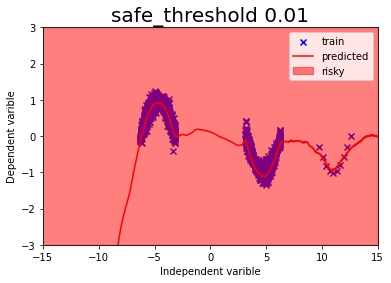

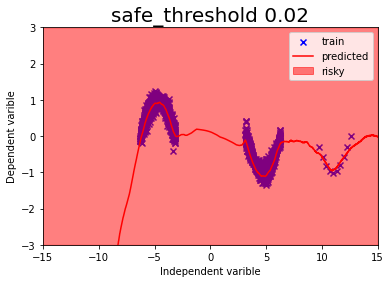

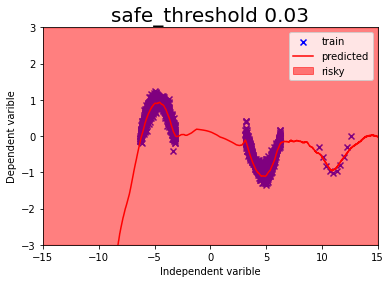

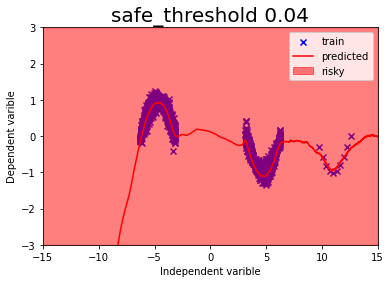

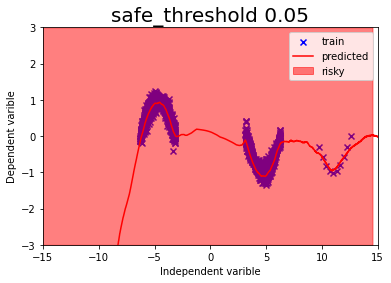

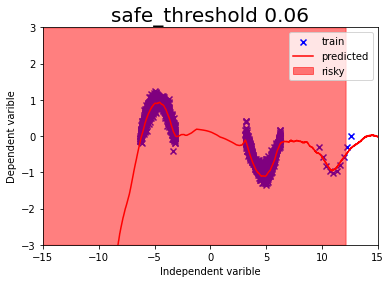

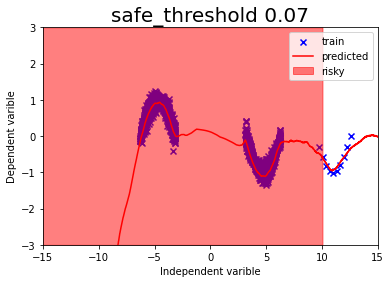

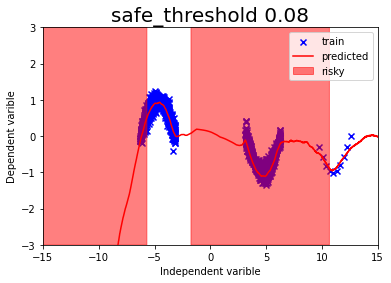

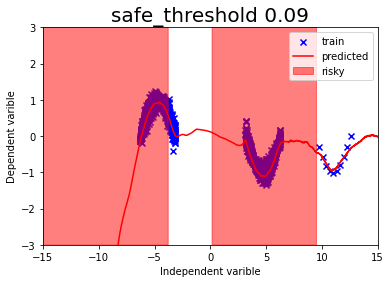

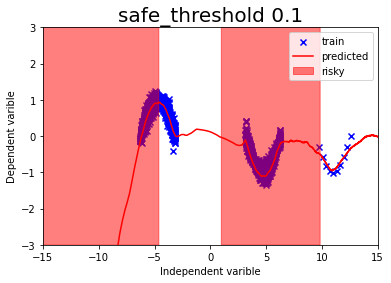

In [77]:
for i, lnr in enumerate(safe_lnrs):
    plot_model(model=lnr,title='safe_threshold {}'.format((i+1)*1e-2))
